In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [3]:
# ===============================================================
# Landmark Recognition - Custom CNN on Rajasthan Dataset
# ===============================================================

import tensorflow as tf
import os
from sklearn.model_selection import train_test_split


# ---------------------------------------------------------------
# 1️⃣ Set Dataset Path
# ---------------------------------------------------------------
DATASET_PATH = "/kaggle/input/rajasthan-dataset/Rajasthan_Landmark_dataset - Copy/Rajasthan_Landmark_dataset - Copy"  # <-- change if needed

IMG_SIZE = (224, 224)
batch_size = 32
EPOCHS = 25

In [16]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

val_gen = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

class_names = train_gen.class_names
NUM_CLASSES = len(class_names)
print(f"Detected {len(class_names)} landmark classes")


Found 7810 files belonging to 49 classes.
Using 6248 files for training.
Found 7810 files belonging to 49 classes.
Using 1562 files for validation.
Detected 49 landmark classes


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_gen = val_gen.cache().prefetch(buffer_size=AUTOTUNE)


In [23]:
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4),
                  input_shape=IMG_SIZE + (3,)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Block 4
    layers.Conv2D(256, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Dense head
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc")]
)

In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,254,481 (4.79 MB)

 Trainable params: 1,252,561 (4.78 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [27]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/25


I0000 00:00:1762060708.622748     102 service.cc:148] XLA service 0x243252f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762060708.623300     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762060709.452907     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/196 ━━━━━━━━━━━━━━━━━━━━ 1:44:21 32s/step - accuracy: 0.0000e+00 - loss: 3.9938 - top3_acc: 0.0000e+00

I0000 00:00:1762060717.452118     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.0928 - loss: 3.7179 - top3_acc: 0.2085
Epoch 1: val_accuracy improved from -inf to 0.12356, saving model to best_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 69s 189ms/step - accuracy: 0.0930 - loss: 3.7168 - top3_acc: 0.2089 - val_accuracy: 0.1236 - val_loss: 4.1845 - val_top3_acc: 0.2644 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2009 - loss: 3.1017 - top3_acc: 0.4014
Epoch 2: val_accuracy did not improve from 0.12356
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.2010 - loss: 3.1013 - top3_acc: 0.4015 - val_accuracy: 0.0704 - val_loss: 8.5933 - val_top3_acc: 0.1709 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2813 - loss: 2.7524 - top3_acc: 0.5052
Epoch 3: val_accuracy improved from 0.12356 to 0.24456, saving model to best_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.2813 - loss: 2.7523 - top3_acc: 0.5053

In [32]:
print("\nEvaluating best model...")
best_model = tf.keras.models.load_model("best_model.keras")
loss, acc, top3 = best_model.evaluate(val_gen)
print(f" Final Accuracy: {acc:.4f} | Top-3 Accuracy: {top3:.4f}")


Evaluating best model...
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9505 - loss: 0.3580 - top3_acc: 0.9829
 Final Accuracy: 0.9456 | Top-3 Accuracy: 0.9834


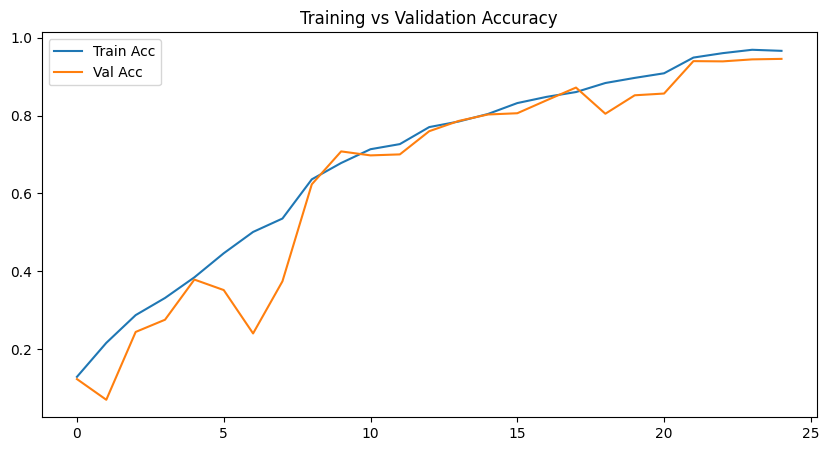

In [33]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [42]:
model_fin = keras.models.load_model("best_model.keras")

# Optionally unfreeze some layers (especially last convolutional block)
# You can print summary to check layer names
for layer in model_fin.layers[-6:]:  # last 6 layers
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Compile with a smaller learning rate for fine-tuning
model_fin.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc")]
)

# Callbacks for continued fine-tuning
fine_tune_callbacks = [
    keras.callbacks.ModelCheckpoint(
        "fine_tuned_model.keras", monitor="val_accuracy",
        save_best_only=True, mode="max", verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3,
        verbose=1, min_lr=1e-6
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5,
        restore_best_weights=True, verbose=1
    )
]


In [43]:
for layer in model_fin.layers:
    print(layer.name, layer.trainable)


conv2d_24 True
batch_normalization_24 True
conv2d_25 True
batch_normalization_25 True
max_pooling2d_9 True
conv2d_26 True
batch_normalization_26 True
conv2d_27 True
batch_normalization_27 True
max_pooling2d_10 True
conv2d_28 True
batch_normalization_28 True
conv2d_29 True
batch_normalization_29 True
max_pooling2d_11 True
conv2d_30 True
batch_normalization_30 True
conv2d_31 True
batch_normalization_31 True
global_average_pooling2d_3 True
dense_5 True
dropout_3 True
dense_6 True


In [44]:

# Continue training
fine_tune_history = model_fin.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # small number for refinement
    callbacks=fine_tune_callbacks
)

# Save final version
model_fin.save("fine_tuned_final.keras")

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9828 - loss: 0.2332 - top3_acc: 0.9984
Epoch 1: val_accuracy improved from -inf to 0.95455, saving model to fine_tuned_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9828 - loss: 0.2332 - top3_acc: 0.9984 - val_accuracy: 0.9545 - val_loss: 0.3236 - val_top3_acc: 0.9853 - learning_rate: 1.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9842 - loss: 0.2174 - top3_acc: 0.9993
Epoch 2: val_accuracy improved from 0.95455 to 0.95647, saving model to fine_tuned_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9842 - loss: 0.2174 - top3_acc: 0.9993 - val_accuracy: 0.9565 - val_loss: 0.3335 - val_top3_acc: 0.9846 - learning_rate: 1.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9813 - loss: 0.2189 - top3_acc: 0.9993
Epoch 3: val_accuracy improved from 0.95647 to 0.96159, saving model to fine_tuned_model.keras
196/196 ━━━━━━━━━━━━

In [45]:
class_names = sorted(os.listdir("/kaggle/input/rajasthan-dataset/Rajasthan_Landmark_dataset - Copy/Rajasthan_Landmark_dataset - Copy"))
